In [1]:
import jax
import jax.numpy as jnp
import mujoco
from mujoco import mjx
from mujoco_logger import SimLog
from robot_descriptions.skydio_x2_mj_description import MJCF_PATH

from mujoco_sysid.mjx.convert import logchol2theta, theta2logchol
from mujoco_sysid.mjx.parameters import get_dynamic_parameters, set_dynamic_parameters

import matplotlib.pyplot as plt

### What is the idea behind the notebook?

- we have gathered some data from the quadrotor running in the simulator
- we have an access to the full state and control inputs
- we want to use this data in MJX to train a model that can identify the dynamical parameters of the quadrotor


In [2]:
model = mujoco.MjModel.from_xml_path(MJCF_PATH)
data = mujoco.MjData(model)
log = SimLog("quadrotor.json")

true_parameters = get_dynamic_parameters(model, 1)
true_parameters

Array([ 1.325   ,  0.      ,  0.      ,  0.0715  ,  0.04051 ,  0.      ,
        0.02927 , -0.0021  ,  0.      ,  0.060528], dtype=float32)

In [3]:
log_qpos = jnp.array(log.data("qpos"))
log_qvel = jnp.array(log.data("qvel"))
log_ctrl = jnp.array(log.data("ctrl"))

log_qpos.shape, log_qvel.shape, log_ctrl.shape

((1001, 7), (1001, 6), (1001, 4))

In [4]:
import jaxlie


@jax.jit
def diff_qpos(qpos1, qpos2):
    # qpos = [x, y, z, qw, qx, qy, qz]
    quat1 = qpos1[3:][jnp.array([3, 0, 1, 2])]
    quat2 = qpos2[3:][jnp.array([3, 0, 1, 2])]
    q1 = jaxlie.SO3.from_quaternion_xyzw(quat1)
    q2 = jaxlie.SO3.from_quaternion_xyzw(quat2)

    return jnp.concatenate([qpos1[:3] - qpos2[:3], jaxlie.SO3.log(q1.inverse() @ q2)])


@jax.jit
def diff_qvel(qvel1, qvel2):
    return qvel1 - qvel2


diff_qpos(log_qpos[0], log_qpos[0]), diff_qvel(log_qvel[0], log_qvel[0])

vmap_diff_qpos = jax.vmap(diff_qpos, in_axes=(0, None))
vmap_diff_qvel = jax.vmap(diff_qvel, in_axes=(0, None))

vmap_diff_qpos(log_qpos, log_qpos[0]), vmap_diff_qvel(log_qvel, log_qvel[0])

(Array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.5354384e-13,
          0.0000000e+00,  0.0000000e+00],
        [-5.7232217e-04,  5.5040164e-07, -4.9597770e-04,  1.0275191e-05,
          1.0678568e-02, -1.0522764e-06],
        [-1.4207972e-03,  1.3654253e-06, -1.2307838e-03,  2.5685134e-05,
          2.6694244e-02, -2.6480807e-06],
        ...,
        [ 3.9635710e-02, -2.3915130e-01,  3.0338511e-02, -1.9615057e-01,
         -6.3093685e-02,  1.5923199e-01],
        [ 4.6400912e-02, -2.3677342e-01,  3.1514063e-02, -1.9395381e-01,
         -6.8520777e-02,  1.5893111e-01],
        [ 5.3117447e-02, -2.3419258e-01,  3.2680660e-02, -1.9162498e-01,
         -7.3916078e-02,  1.5861784e-01]], dtype=float32),
 Array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-2.84185503e-02,  2.73143050e-05, -2.46452875e-02,
          5.13718231e-04,  5.33897042e-01,  5.28622550e-05],
        [-5.60338274e-02,  5.37765154e

In [5]:
mjx_model = mjx.put_model(model)


def smart_step(vel, pos, ctrl, parameters):
    # update the parameters
    new_model = set_dynamic_parameters(mjx_model, 1, parameters)

    mjx_data = mjx.make_data(new_model)
    # set initial data for the step
    mjx_data = mjx_data.replace(qvel=vel, qpos=pos, ctrl=ctrl)
    # step the simulation
    mjx_data = mjx.step(new_model, mjx_data)
    return mjx_data.qpos, mjx_data.qvel


smart_step = jax.jit(smart_step)

In [6]:
true_parameters

Array([ 1.325   ,  0.      ,  0.      ,  0.0715  ,  0.04051 ,  0.      ,
        0.02927 , -0.0021  ,  0.      ,  0.060528], dtype=float32)

In [7]:
N_SAMPLES = 1_0000
key = jax.random.PRNGKey(0)


vmapped_logchol2theta = jax.vmap(logchol2theta)


@jax.jit
def sample_parameters(theta):
    """
    Get theta estimate (10,) and return (N_SAMPLES, 10)
    """
    logchol = theta2logchol(theta)
    distrib = jax.random.normal(key, shape=(N_SAMPLES, logchol.shape[0])) * 0.1
    logchol = jnp.array([logchol] * N_SAMPLES)

    # cast to theta backward
    new_logchol = logchol + distrib
    return new_logchol
    # return vmapped_logchol2theta(new_logchol)


sample_parameters(true_parameters).shape

(10000, 10)

In [8]:
vmapped_step = jax.vmap(smart_step, in_axes=(0, 0, None, 0))
# vmapped_step(log_qvel[0], log_qpos[0], log_ctrl[0], sample_parameters(true_parameters))

In [9]:
# def compute_error(logchols):
#     thetas = vmapped_logchol2theta(logchols)
#     qpos = log_qpos[0]
#     qvel = log_qvel[0]

#     qpos = jnp.array([qpos] * N_SAMPLES)
#     qvel = jnp.array([qvel] * N_SAMPLES)

#     errors = jnp.zeros(N_SAMPLES)

#     for i in range(len(log_qpos) - 1):
#         ctrl = log_ctrl[i]
#         qpos, qvel = vmapped_step(qvel, qpos, ctrl, thetas)

#         next_qpos = log_qpos[i + 1]
#         next_qvel = log_qvel[i + 1]

#         errors += jnp.linalg.norm(vmap_diff_qpos(qpos, next_qpos), axis=1) ** 2
#         errors += jnp.linalg.norm(vmap_diff_qvel(qvel, next_qvel), axis=1) ** 2

#     # replace nan with 1e10
#     errors = jnp.where(jnp.isnan(errors), 1e10, errors)

#     return errors


# # compute_error = jax.jit(compute_error)


In [10]:
import jax
import jax.numpy as jnp


def compute_error(logchols):
    thetas = vmapped_logchol2theta(logchols)
    qpos0 = log_qpos[0]
    qvel0 = log_qvel[0]

    qpos = jnp.tile(qpos0[None, :], (N_SAMPLES, 1))
    qvel = jnp.tile(qvel0[None, :], (N_SAMPLES, 1))

    errors = jnp.zeros(N_SAMPLES)

    def step_fn(carry, inputs):
        qpos, qvel, errors = carry
        ctrl, next_qpos, next_qvel = inputs

        # Update the positions and velocities
        qpos, qvel = vmapped_step(qvel, qpos, ctrl, thetas)

        # # Compute the differences
        # next_qpos = jnp.broadcast_to(next_qpos, qpos.shape)
        # next_qvel = jnp.broadcast_to(next_qvel, qvel.shape)

        diff_qpos = vmap_diff_qpos(qpos, next_qpos)
        diff_qvel = vmap_diff_qvel(qvel, next_qvel)

        # Accumulate the squared errors
        errors += jnp.linalg.norm(diff_qpos, axis=1) ** 2
        errors += jnp.linalg.norm(diff_qvel, axis=1) ** 2

        return (qpos, qvel, errors), None

    # Prepare inputs for scanning
    inputs = (log_ctrl[:-1], log_qpos[1:], log_qvel[1:])

    # Run the scan
    (qpos, qvel, errors), _ = jax.lax.scan(step_fn, (qpos, qvel, errors), inputs)

    # Replace NaNs with a large constant
    errors = jnp.where(jnp.isnan(errors), 1e10, errors)

    return errors


# JIT-compile the compute_error function
compute_error = jax.jit(compute_error)

(0.0, 10000000.0)

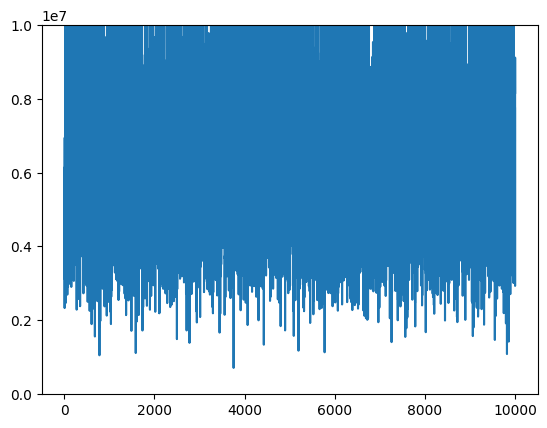

In [11]:
params = sample_parameters(true_parameters)

errors = compute_error(params)
plt.plot(errors)
plt.ylim(0, 1e7)

In [12]:
# find the best parameters
idx = jnp.argmin(errors)
best_parameters = params[idx]

logchol2theta(best_parameters)

Array([ 0.8074798 , -0.07318472,  0.03947093,  0.06483882,  0.0323291 ,
       -0.00750011,  0.02831798,  0.00617214, -0.00332549,  0.04939768],      dtype=float32)

In [13]:
lambda_ = 1e-10
weights = jnp.zeros(N_SAMPLES)
for i in range(N_SAMPLES):
    error = errors[i]
    weights = weights.at[i].set(jnp.exp(-error * lambda_))

weights /= jnp.sum(weights)
# use the weights to compute the new parameters
new_parameters = jnp.sum(weights[:, None] * params, axis=0)

logchol2theta(new_parameters)

Array([ 1.3243315e+00,  1.7682264e-03, -6.2414550e-04,  7.1312100e-02,
        4.0408757e-02, -4.3045881e-04,  2.9522447e-02, -2.2376636e-03,
       -6.0563384e-06,  6.0714357e-02], dtype=float32)

In [14]:
def optimize(theta0):
    ITERATIONS = 1

    theta = theta0
    for idx in range(ITERATIONS):
        logchols = sample_parameters(theta)
        errors = compute_error(logchols)

        weights = jnp.zeros(N_SAMPLES)
        lambda_ = 1e-9
        for i in range(N_SAMPLES):
            error = errors[i]
            if jnp.isinf(error):
                weights = weights.at[i].set(0)
            else:
                weights = weights.at[i].set(jnp.exp(-error * lambda_))

        weights /= jnp.sum(weights)
        new_parameters = jnp.sum(weights[:, None] * params, axis=0)
        theta = logchol2theta(new_parameters)

        print(f"Step: {idx}, Error: {errors.mean()} Theta: {theta}")

    return theta


true_logchol = theta2logchol(true_parameters)
true_logchol += jax.random.normal(key, shape=true_logchol.shape) * 1.0
test_theta = logchol2theta(true_logchol)

last_theta = optimize(test_theta)

Step: 0, Error: 60132836.0 Theta: [ 1.3237695e+00  1.8411524e-03 -4.2887210e-04  7.1279660e-02
  4.0397435e-02 -4.0814295e-04  2.9473044e-02 -2.2328785e-03
  2.1756465e-05  6.0657702e-02]


In [18]:
test_theta

Array([ 0.62951267, -0.37195644,  0.4606074 ,  0.39109412,  0.60648423,
        0.25216666,  0.8309115 ,  0.235475  , -0.28505576,  0.9512827 ],      dtype=float32)

In [15]:
true_parameters

Array([ 1.325   ,  0.      ,  0.      ,  0.0715  ,  0.04051 ,  0.      ,
        0.02927 , -0.0021  ,  0.      ,  0.060528], dtype=float32)

In [16]:
last_theta

Array([ 1.3237695e+00,  1.8411524e-03, -4.2887210e-04,  7.1279660e-02,
        4.0397435e-02, -4.0814295e-04,  2.9473044e-02, -2.2328785e-03,
        2.1756465e-05,  6.0657702e-02], dtype=float32)

In [17]:
jnp.linalg.norm(theta2logchol(last_theta) - theta2logchol(true_parameters))

Array(0.00317886, dtype=float32)